In [1]:
pwd

'/Users/in-divye.singh/Documents/Projects/MIC_predictor/notebooks/classifier'

In [2]:
cd ../../

/Users/in-divye.singh/Documents/Projects/MIC_predictor


In [3]:
from notebooks.utils import *

In [4]:
import biovec
import numpy as np
import pandas as pd
from itertools import chain
from collections import Counter

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from sklearn.svm import SVC
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
from sklearn.metrics import classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split

In [7]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [8]:
avp_ic50 = pd.read_csv("data/raw/AVP-IC50Pred_train.csv")
ha_avp = pd.read_csv("data/raw/HA_AVP.csv")

df = pd.concat([avp_ic50[['Sequence','MIC']], ha_avp], axis=0).drop_duplicates(['Sequence']).reset_index(drop=True)
df = sequence_filtering(df)

In [9]:
df['lessthan5'] = df['MIC'].apply(lambda mic: 1 if mic <= 5 else 0)

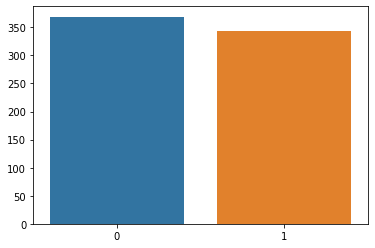

In [10]:
count = dict(Counter(df['lessthan5']))
sns.barplot(x = [str(k) for k in count.keys()], y=[float(v) for v in count.values()])

In [11]:
def get_score(y_true, y_pred):
    print(f'Accuracy: {round(accuracy_score(y_true, y_pred), 4)}')
    print(f'F1-score: {round(f1_score(y_true, y_pred), 4)}')
    print(f'AUROC: {round(roc_auc_score(y_true, y_pred), 4)}')
    print(f'MCC: {round(matthews_corrcoef(y_true, y_pred), 4)}')
    print(classification_report(y_test, y_pred))

### ProtVec

In [13]:
############# Prot2Vec #############
uniprot_embedding = biovec.models.load_protvec("data/embeddings/uniprot__kmer_3_contextWindow_10_vector_100_reduction_None")

avg_vectors = convert_sequences_to_avg_vectors(df['Sequence'], uniprot_embedding)
avg_vectors = avg_vectors.reset_index(drop=True)

Creating vectors: 100%|██████████| 712/712 [00:00<00:00, 1150.29sequence/s]


In [46]:
X_train, X_test, y_train, y_test = train_test_split(avg_vectors, df['lessthan5'], test_size=0.2, random_state=42)

In [47]:
X_train.shape, X_test.shape

((569, 100), (143, 100))

In [52]:
rf = RandomForestClassifier(class_weight="balanced")

In [53]:
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [54]:
y_pred = rf.predict(X_test)

In [55]:
get_score(y_test, y_pred)

Accuracy: 0.7343
F1-score: 0.6833
AUROC: 0.7272
MCC: 0.4544
              precision    recall  f1-score   support

           0       0.77      0.77      0.77        83
           1       0.68      0.68      0.68        60

    accuracy                           0.73       143
   macro avg       0.73      0.73      0.73       143
weighted avg       0.73      0.73      0.73       143



In [56]:
mcc_scorer = make_scorer(matthews_corrcoef)

In [57]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [None, 80, 90, 100, 110],
    'max_features': ['auto', 2, 3],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 8, 10, 12],
    'n_estimators': [100, 200, 300, 500]
}
# Create a based model
rf = RandomForestClassifier(class_weight="balanced")
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 1, scoring=mcc_scorer)

In [58]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:  5.9min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [None, 80, 90, 100, 110],
                         'max_features': ['auto', 2, 3],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 8, 10, 12],
                         'n_estimators': [100, 200, 300, 500]},
             scoring=make_scorer(matthews_corrcoef), verbose=1)

In [59]:
grid_search.best_params_

{'max_depth': 90,
 'max_features': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

In [68]:
rf_clf = RandomForestClassifier(class_weight='balanced', **grid_search.best_params_)

In [105]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=90, max_features=2,
                       n_estimators=500)

In [106]:
best_grid = grid_search.best_estimator_

In [107]:
y_pred = rf_clf.predict(X_test)

In [108]:
get_score(y_test, y_pred)

Accuracy: 0.7483
F1-score: 0.7049
AUROC: 0.7439
MCC: 0.4857
              precision    recall  f1-score   support

           0       0.79      0.77      0.78        83
           1       0.69      0.72      0.70        60

    accuracy                           0.75       143
   macro avg       0.74      0.74      0.74       143
weighted avg       0.75      0.75      0.75       143



### ProtVec + AA frequence

In [21]:
aa_freq = reduce_by_kmer_frequency(df)

In [22]:
protvec_aa_freq = pd.concat([avg_vectors, aa_freq], axis=1)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(protvec_aa_freq, df['lessthan5'], test_size=0.2, random_state=42)

In [24]:
X_train.shape, X_test.shape

((569, 120), (143, 120))

In [25]:
rf = RandomForestClassifier(class_weight="balanced")

In [26]:
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [27]:
y_pred = rf.predict(X_test)

In [28]:
get_score(y_test, y_pred)

Accuracy: 0.7203
F1-score: 0.6825
AUROC: 0.7198
MCC: 0.4351
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        83
           1       0.65      0.72      0.68        60

    accuracy                           0.72       143
   macro avg       0.72      0.72      0.72       143
weighted avg       0.73      0.72      0.72       143



### ProtVec + dipep freq

In [29]:
dipep_freq = reduce_by_kmer_frequency(df, kmer=2)

In [30]:
protvec_dipep_freq = pd.concat([avg_vectors, dipep_freq], axis=1)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(protvec_dipep_freq, df['lessthan5'], test_size=0.2, random_state=42)

In [32]:
X_train.shape, X_test.shape

((569, 500), (143, 500))

In [33]:
rf = RandomForestClassifier(class_weight="balanced")

In [34]:
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [35]:
y_pred = rf.predict(X_test)

In [36]:
get_score(y_test, y_pred)

Accuracy: 0.7343
F1-score: 0.6984
AUROC: 0.7341
MCC: 0.4635
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        83
           1       0.67      0.73      0.70        60

    accuracy                           0.73       143
   macro avg       0.73      0.73      0.73       143
weighted avg       0.74      0.73      0.74       143



### ProtVec + AA frequence + Dipeptide frequency

In [37]:
protvec_aa_dipep = pd.concat([avg_vectors, aa_freq, dipep_freq], axis=1)

In [124]:
X_train, X_test, y_train, y_test = train_test_split(protvec_aa_dipep, df['lessthan5'], test_size=0.2, random_state=42)

In [125]:
X_train.shape, X_test.shape

((569, 520), (143, 520))

In [40]:
rf = RandomForestClassifier(class_weight="balanced")

In [41]:
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [42]:
y_pred = rf.predict(X_test)

In [43]:
get_score(y_test, y_pred)

Accuracy: 0.7343
F1-score: 0.6935
AUROC: 0.7318
MCC: 0.4602
              precision    recall  f1-score   support

           0       0.78      0.75      0.77        83
           1       0.67      0.72      0.69        60

    accuracy                           0.73       143
   macro avg       0.73      0.73      0.73       143
weighted avg       0.74      0.73      0.74       143



### Feature selection - Boruta

In [45]:
from boruta import BorutaPy

In [119]:
boruta = BorutaPy(estimator = rf_clf, n_estimators = 'auto', max_iter = 10000)

In [120]:
boruta.fit(protvec_aa_dipep.values, df['lessthan5'])

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=90,
                                          max_features=2, n_estimators=4,
                                          random_state=RandomState(MT19937) at 0x10ABEABA0),
         max_iter=10000, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x10ABEABA0)

In [127]:
train_features_selected = X_train[X_train.columns[boruta.support_]]
test_features_selected = X_test[X_test.columns[boruta.support_]]

In [139]:
rf_clf = RandomForestClassifier(class_weight='balanced')

In [140]:
rf_clf.fit(train_features_selected, y_train)

RandomForestClassifier(class_weight='balanced')

In [141]:
y_pred = rf_clf.predict(test_features_selected)

In [142]:
get_score(y_test, y_pred)

Accuracy: 0.7413
F1-score: 0.7218
AUROC: 0.7494
MCC: 0.4924
              precision    recall  f1-score   support

           0       0.83      0.70      0.76        83
           1       0.66      0.80      0.72        60

    accuracy                           0.74       143
   macro avg       0.74      0.75      0.74       143
weighted avg       0.76      0.74      0.74       143



In [143]:
train_features_selected

,17,21,22,38,54,98,99
375,-0.061637,-0.027278,-0.029913,-0.003584,0.037267,0.034154,-0.083899
344,-0.081769,-0.040339,0.011841,-0.014277,0.059836,0.076746,-0.089298
526,-0.101111,-0.022985,-0.037642,0.021496,0.045719,0.056302,-0.008504
24,-0.047875,-0.055600,-0.055407,-0.005019,0.066954,0.080306,-0.058702
234,-0.086294,-0.041060,-0.030591,-0.015052,0.003767,0.065959,-0.061276
...,...,...,...,...,...,...,...
71,-0.055734,-0.022597,0.000421,-0.006368,-0.003458,0.046634,-0.040752
106,-0.059770,-0.057631,0.012477,0.029456,-0.022868,0.023963,-0.075192
270,-0.101178,0.010327,-0.025779,-0.003149,0.035033,0.060443,0.005916
435,-0.030026,-0.042137,-0.003907,0.011918,-0.000200,0.053453,-0.042426


### Hyperparameter tuning

In [ ]:
mcc_scorer = make_scorer(matthews_corrcoef)

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [None, 80, 90, 100, 110],
    'max_features': ['auto', 2, 3],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 8, 10, 12],
    'n_estimators': [100, 200, 300, 500]
}
# Create a based model
rf = RandomForestClassifier(class_weight="balanced")
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 1, scoring=mcc_scorer)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
best_grid = grid_search.best_estimator_

In [ ]:
y_pred = best_grid.predict(X_test)

In [ ]:
get_score(y_test, y_pred)

### feature selection

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector

In [ ]:
rf_clf = RandomForestClassifier(class_weight='balanced', max_depth=80, max_features=0.005, min_samples_leaf=1,
                                min_samples_split=10, n_estimators=300)

In [ ]:
selector = SequentialFeatureSelector(rf_clf, k_features='best', forward=False, verbose=2,
                                     scoring=mcc_scorer, cv=5, n_jobs=-1)

In [ ]:
selector.fit(aa_dipep_freq, df['lessthan5'])

In [ ]:
len(selector.k_feature_idx_)

In [ ]:
aa_dipep_freq.columns[selector.support_]

In [ ]:
train_features_selected = selector.transform(X_train)
test_features_selected = selector.transform(X_test)

In [ ]:
rf_clf = RandomForestClassifier(class_weight='balanced', **grid_search.best_params_)

In [ ]:
rf_clf.fit(train_features_selected, y_train)

In [ ]:
y_pred = rf_clf.predict(test_features_selected)

In [ ]:
get_score(y_test, y_pred)